In [3]:
import crystal_plasticity_module as cp
from scipy.signal import savgol_filter
from scipy.optimize import fsolve, minimize,basinhopping
import itertools
import yieldfuncs as yf
import f2py_yldfit as fyf
import numpy as np
import os
import matplotlib.pyplot as plt

# no elasticity
elasticity = None
# choose the crystallography of the grains
crystal_structure = 'FCC_111'
grain_interaction = 'FCTAYLOR'   # Taylor model without grain interactions
hardening_law = {'model'                : 'RIGID_PLASTIC',    # rigid plasticity with a given critical stress
                 'hardening_parameters' : [10.],              # CRSS [MPa]
                 'relax_penalties'      : [0., 0., 0.]}       # [MPa]
S_direction = None
# prescribed absolute stress components
S_absolute = None

# bool array for indicating known (True) and unknown (False) terms in both vel. gradient and stress tensor
iL = True
iS_direction = False
iS_absolute = False
# number of computation steps
Nsteps = 25
# time increment
dt = 0.01
# run with elasticity or without
run_elasticity = False
# set export options
results_output_options = {'grain_results'       : ['euler_angles','sliprates','crss','relaxation','stress_loc'],
                          'polycrystal_results' : ['average_stress','average_slip'],
                          'number_of_outputs'   : Nsteps}
dofortran = True


def create_L_array(num_of_Ls, start=0, end=2*np.pi):
    thetas = np.linspace(start, end, num_of_Ls)
    L_array = np.zeros((3, 3, num_of_Ls))  # Initialize the 3x3xn array

    for i, theta in enumerate(thetas):
        diag_values = np.array([np.cos(theta), np.sin(theta), -np.cos(theta) - np.sin(theta)])
        vonMisesNorm = np.sqrt(2/3) * np.linalg.norm(diag_values)
        diag_values /= vonMisesNorm  # Normalize

        L = np.zeros((3, 3))  # Create the 3x3 tensor
        L[0, 0] = diag_values[0]
        L[1, 1] = diag_values[1]
        L[2, 2] = diag_values[2]

        L_array[:, :, i] = L  # Store in the array

    return L_array[:,:,:-1]


S_list = np.load('out5D.npy')

# Create directory if it doesn't exist
output_folder = "Yield_surfaces_25%"
os.makedirs(output_folder, exist_ok=True)



In [22]:
threshold = 1e-9
def yield_loci(start,end):
    gradients = create_L_array(9, 0, 2*np.pi)
    selections = list(itertools.product(range(np.size(gradients, axis=2)), repeat=3))

    # Loop through all matrix combinations
    for (i, j, k) in selections[start:end]:
        combination = tuple(np.where(abs(matrix) < threshold, 0, matrix) for matrix in (gradients[:, :, i], gradients[:, :, j], gradients[:, :, k]))

        orientations = {}
        orientations['grains'] = np.loadtxt(r'Rand1000.tex', skiprows=4, usecols=(0,1,2))
        polycrystal = cp.Polycrystal(crystal_structure, orientations, elasticity, hardening_law, grain_interaction)
        
        cumulative_strain = 0  # Start at 0% strain for each combination

        for L in combination:
            for step in range(2):  # Each L should do 2 steps (25% increments)
                print(type(L))
                L = np.array(L)
                polycrystal.load(L, S_direction, S_absolute, iL, iS_direction, iS_absolute,
                                 Nsteps, dt, run_elasticity, results_output_options, dofortran)

                cumulative_strain += Nsteps  # Increment strain level
                print(f'Texture simulation done ({cumulative_strain}% strain), current gradient: {L}')

                # Calculate yield locus
                YL, R, non_converg_stress = polycrystal.yield_locus(
                    locus_type='full', user_input=S_list, input_type='strain', number_of_points=10000)

                print(f'Yield surface after {cumulative_strain}% strain: {YL[:,:,0]}, non_converg_stress: {non_converg_stress}')

                # Save yield locus with the correct strain level in the filename
                filename = f"YL_{cumulative_strain}%_{i}{j}{k}.npy"
                filepath = os.path.join(output_folder, filename)
                np.save(filepath, YL)
                print(f"Saved {filename} to {output_folder}")
            
yield_loci(486,487)

<class 'numpy.ndarray'>
Texture simulation done (25% strain), current gradient: [[ 0.8660254  0.         0.       ]
 [ 0.        -0.8660254  0.       ]
 [ 0.         0.         0.       ]]
Yield surface after 25% strain: [[ 1.79589371 10.1118712  -7.4657571 ]
 [10.1118712   3.09542402 11.16775527]
 [-7.4657571  11.16775527 -4.89131773]], non_converg_stress: 0
Saved YL_25%_746.npy to Yield_surfaces_25%
<class 'numpy.ndarray'>
Texture simulation done (50% strain), current gradient: [[ 0.8660254  0.         0.       ]
 [ 0.        -0.8660254  0.       ]
 [ 0.         0.         0.       ]]
Yield surface after 50% strain: [[-9.99223845  2.47454498  2.65204661]
 [ 2.47454498 -6.69351252 -9.19737088]
 [ 2.65204661 -9.19737088 16.68575097]], non_converg_stress: 0
Saved YL_50%_746.npy to Yield_surfaces_25%
<class 'numpy.ndarray'>
Texture simulation done (75% strain), current gradient: [[-0.8660254  0.         0.       ]
 [ 0.         0.         0.       ]
 [ 0.         0.         0.8660254]]
Y

In [ ]:
# L=[[-0.5,0,0], [0,0.5,0],[0,0,-1]]
L=[[-0.87,0,0], [0,0,0],[0,0,0.87]]

In [11]:
orientations = {}
orientations['grains'] = np.loadtxt(r'Rand1000.tex', skiprows=4, usecols=(0,1,2))
polycrystal = cp.Polycrystal(crystal_structure, orientations, elasticity, hardening_law, grain_interaction)

In [17]:


polycrystal.load(L, S_direction, S_absolute, iL, iS_direction, iS_absolute,
                                 Nsteps, dt, run_elasticity, results_output_options, dofortran)        

In [18]:
YL, R, non_converg_stress = polycrystal.yield_locus(
                    locus_type='full', user_input=S_list, input_type='strain', number_of_points=10000)

print(YL[:,:,0])

[[-3.62390814  7.20966518 10.98772181]
 [ 7.20966518 -6.47506718  7.53034178]
 [10.98772181  7.53034178 10.09897532]]


In [ ]:
with np.load("final_results.npz") as data:
    print(np.max(data["all_coefs"]),np.max(data["all_exps"]),np.where(data["all_res"]==data["all_res"].max()),data["all_res"].shape)

3.327598067215218 22.923382535326688 (array([3], dtype=int64), array([372], dtype=int64)) (7, 512)


In [ ]:
orientations = {}
orientations['grains'] = np.loadtxt(r'Rand1000.tex', skiprows=4, usecols=(0,1,2))
polycrystal = cp.Polycrystal(crystal_structure, orientations, elasticity, hardening_law, grain_interaction)
        

In [23]:
folder_path = "Yield_surfaces_25%"

# List all .npy files
files = os.listdir(folder_path)

# Extract strain and combination for sorting
sorted_files = sorted(files, key=lambda f: (int(f.split("_")[1][:-1]), int(f.split("_")[2].split(".")[0])))

# Print confirmation
print(f"Found {len(sorted_files)} files.")

# Define strain levels and mapping
strain_levels = [25, 50, 75, 100, 125, 150]
strain_map = {strain: idx for idx, strain in enumerate(strain_levels)}

def coefficient_calculator_new(folder, rerun_cases=None, checkpoint_file="checkpoint.npz", final_file="final_results.npz"):
    coefs = np.ones(16)
    a = 8.0
    NT = 1 
    sigY = 30.0
    coefs = np.concatenate((coefs, [a]))
    model = 'YLD2004_18p'

    all_data = {
        "all_coefs": np.zeros((18, 7, 512)),
        "all_exps": np.zeros((7, 512)),
        "all_res": np.zeros((7, 512)),
    }

    # Load checkpoint if it exists
    if os.path.exists(checkpoint_file):
        all_data.update(np.load(checkpoint_file))
        print("Checkpoint loaded successfully.")

    bounds = [tuple(x) for x in len(coefs) * [[None, None]]]
    bounds[-1] = (2, 50)
    bounds = tuple(bounds)

    for file in folder:
        parts = file.split("_")
        strain = int(parts[1][:-1])
        combination_octal = parts[2].split(".")[0]
        comb_idx = int(combination_octal, 8)
        strain_idx = strain_map[strain]

        # Skip cases unless they are in the rerun list or haven't been processed
        if rerun_cases is not None:
            if (comb_idx) not in rerun_cases and all_data["all_exps"][strain_idx, comb_idx] != 0:
                continue  

        print(f"Processing file: {file} -> strain: {strain}, strain_idx: {strain_idx}, combination: {combination_octal}, comb_idx: {comb_idx}")

        s = np.load(os.path.join(folder_path, file))
        fyf.py2f_yldfun.py2f_stresses(s)

        sol = basinhopping(yf.get_coefa, x0=coefs, niter=10, T=10, stepsize=0.5, 
                           minimizer_kwargs={'method': 'slsqp', 'args': (model, NT, sigY), 
                                             'bounds': bounds, 'tol': 1e-10}, 
                           interval=4, disp=True)

        all_data["all_coefs"][:, strain_idx, comb_idx] = np.concatenate(([1, 1], sol.x[:-1]))
        all_data["all_exps"][strain_idx, comb_idx] = sol.x[-1]
        all_data["all_res"][strain_idx, comb_idx] = sol.fun

        print(f"Residual: {all_data['all_res'][strain_idx, comb_idx]} | Strain Index: {strain_idx} | Combination Index: {comb_idx}")

        # Save checkpoint (intermediate results)
        np.savez(checkpoint_file, **all_data)
        print(f"Checkpoint saved to {checkpoint_file}")

    
    np.savez(final_file, **all_data)
    print(f"Final results saved to {final_file}")


rerun_cases = [(103), (107), (372),(486)]







Found 3072 files.


In [24]:
coefficient_calculator_new(sorted_files, rerun_cases=rerun_cases)

Checkpoint loaded successfully.
Processing file: YL_25%_147.npy -> strain: 25, strain_idx: 0, combination: 147, comb_idx: 103
basinhopping step 0: f 312.678
basinhopping step 1: f 312.678 trial_f 312.678 accepted 1  lowest_f 312.678
found new global minimum on step 1 with function value 312.678
basinhopping step 2: f 312.678 trial_f 312.678 accepted 1  lowest_f 312.678
found new global minimum on step 2 with function value 312.678
basinhopping step 3: f 323.822 trial_f 323.822 accepted 1  lowest_f 312.678
adaptive stepsize: acceptance rate 0.750000 target 0.500000 new stepsize 0.555556 old stepsize 0.5
basinhopping step 4: f 312.681 trial_f 312.681 accepted 1  lowest_f 312.678
basinhopping step 5: f 312.678 trial_f 312.678 accepted 1  lowest_f 312.678
basinhopping step 6: f 312.678 trial_f 312.678 accepted 1  lowest_f 312.678
basinhopping step 7: f 312.678 trial_f 312.678 accepted 1  lowest_f 312.678
adaptive stepsize: acceptance rate 0.875000 target 0.500000 new stepsize 0.617284 old 

In [ ]:
with np.load(r'final_results.npz') as data:
    all_res = data["all_res"]

print(all_res[:,5])

[273.57119156 394.62785055 576.86234125 768.19298563 838.98932026
 883.421591     0.        ]


In [ ]:
threshold = 1e-6
gradients = create_L_array(9)
selections = list(itertools.product(range(np.size(gradients, axis=2)), repeat=3))
print(selections)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 0, 5), (0, 0, 6), (0, 0, 7), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 1, 6), (0, 1, 7), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 2, 4), (0, 2, 5), (0, 2, 6), (0, 2, 7), (0, 3, 0), (0, 3, 1), (0, 3, 2), (0, 3, 3), (0, 3, 4), (0, 3, 5), (0, 3, 6), (0, 3, 7), (0, 4, 0), (0, 4, 1), (0, 4, 2), (0, 4, 3), (0, 4, 4), (0, 4, 5), (0, 4, 6), (0, 4, 7), (0, 5, 0), (0, 5, 1), (0, 5, 2), (0, 5, 3), (0, 5, 4), (0, 5, 5), (0, 5, 6), (0, 5, 7), (0, 6, 0), (0, 6, 1), (0, 6, 2), (0, 6, 3), (0, 6, 4), (0, 6, 5), (0, 6, 6), (0, 6, 7), (0, 7, 0), (0, 7, 1), (0, 7, 2), (0, 7, 3), (0, 7, 4), (0, 7, 5), (0, 7, 6), (0, 7, 7), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 0, 4), (1, 0, 5), (1, 0, 6), (1, 0, 7), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 4), (1, 1, 5), (1, 1, 6), (1, 1, 7), (1, 2, 0), (1, 2, 1), (1, 2, 2), (1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 2, 6), (1, 2, 7), (1, 3, 0), (1, 3, 1), (1, 3, 2)

In [ ]:
for (i,j,k) in selections[:3]:
    print(i,j,k)
    combination = tuple(np.where(abs(matrix) < threshold, 0, matrix) for matrix in (gradients[:, :, i], gradients[:, :, j], gradients[:, :, k]))
    for L in combination[:3]:
        print(L)

In [ ]:
orientations = {}
orientations['grains'] = np.loadtxt(r'Rand1000.tex', skiprows=4, usecols=(0,1,2))
polycrystal = cp.Polycrystal(crystal_structure, orientations, elasticity, hardening_law, grain_interaction)
        

In [ ]:
Nsteps = 25
for (i,j,k) in selections[0:1]:
    print(i,j,k)
    combination = tuple(np.where(abs(matrix) < threshold, 0, matrix) for matrix in (gradients[:, :, i], gradients[:, :, j], gradients[:, :, k]))
    for L in combination:
         for step  in range(2):
            print(L)
            polycrystal.load(L, S_direction, S_absolute, iL, iS_direction, iS_absolute,
                                    Nsteps, dt, run_elasticity, results_output_options, dofortran)

In [ ]:
YL, R, non_converg_stress = polycrystal.yield_locus(
                    locus_type='full', user_input=S_list, input_type='strain', number_of_points=10000)



In [ ]:
coefs = np.ones(16)
a = 8.0
NT = 1 
sigY = 30.0
coefs = np.concatenate((coefs, [a]))
model = 'YLD2004_18p' 

yfun = {'func':model, 
        'coef':coefs, 
        'exp':a, 
        'Ntransf':NT,
        'y0':sigY}

bounds = [tuple(x) for x in len(coefs) * [[None, None]]]
bounds[-1] = (2, 50)
bounds = tuple(bounds)

fyf.py2f_yldfun.py2f_stresses(YL)

sol = basinhopping(yf.get_coefa, x0=coefs, niter=20, T=10, stepsize=0.5, 
                        minimizer_kwargs={'method': 'slsqp', 'args': (model, NT, sigY), 
                                            'bounds': bounds, 'tol': 1e-10}, 
                        interval=4, disp=True)

yfun['coef'] =  np.concatenate(([1, 1], sol.x[:-1]))
yfun['exp'] = sol.x[-1]
yfun['res'] =  sol.fun

Text(0.5, 0, '$\\sigma_{11}$')

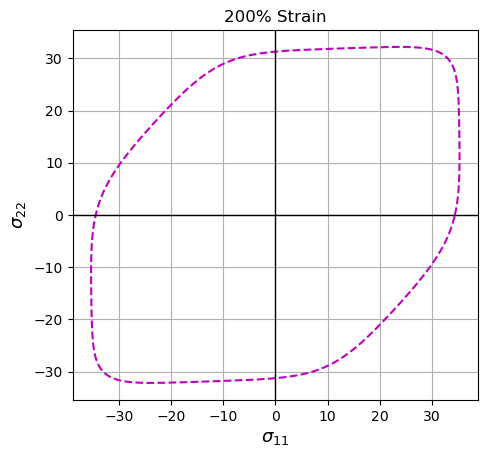

In [ ]:
fig, ax  = plt.subplots()
plots = [('11','22','12',[0])]
gs = yf.genStresses(400, yfun, plot_axes=plots[0], save2file=False)
ax.plot(gs[0,0], gs[1,1], "--",color = 'm')
ax.set_title("200% Strain")
ax.axhline(0, color='black', linewidth=1)  
ax.axvline(0, color='black', linewidth=1)
ax.set_aspect('equal')
ax.grid(True)
ax.set_ylabel(r'$\sigma_{22}$',fontsize=13)
ax.set_xlabel(r'$\sigma_{11}$',fontsize=13)

NameError: name 'YL' is not defined